### HW6. Stokes second problem
### 2022313047 Boyeon,Kim

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import linalg
import pandas as pd
from scipy.linalg import solve_banded

In [48]:
# Set plot params
plt.rcParams['figure.figsize'] = [5,5]
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['xtick.minor.size'] = 3.5
plt.rcParams['ytick.minor.size'] = 3.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.width'] = 1.5
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

#### Consider an infinitely extended flat wall carrying out harmonic oscillation in its own plane (see Figure 1). Due to the no-slip condition, the flow velocity at the wall (where $y = 0$) is $u(0, t) = U_0 cos(nt)$.

#### Check the Exact solution

In [49]:
def exact_solution(n, nu, y, t):
    etas = np.sqrt(n/(2*nu)) * y
    return np.cos(n*t - etas) * np.exp(-etas)

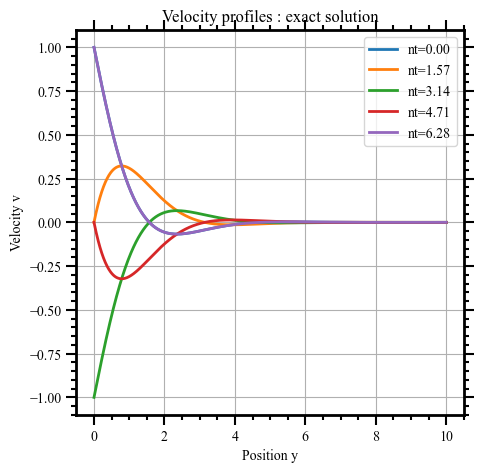

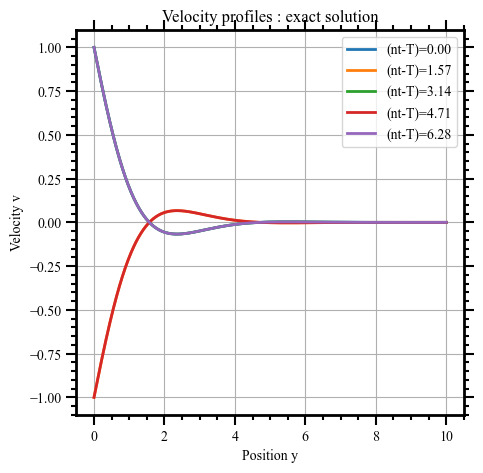

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Given parameters
nu = 1
n = 2
U0 = 1
L = 10
T = 10 * np.pi
dt = 0.001
dy = 0.01

# Discretize the spatial domain
y = np.arange(0, L+dy, dy)

# Calculate eta
eta = np.sqrt(n / (2 * nu)) * y

# Time values for nt and nt - T
nts = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
nts_T = [value + T for value in nts]

# Calculate the exact solution at nt values
u_exact_nt = [U0 * np.exp(-eta) * np.cos(t - eta) for t in nts]
u_exact_nt_T = [U0 * np.exp(-eta) * np.cos(n*t - eta) for t in nts_T]

# Plot the velocity profiles at nt values
for i in range(len(nts)):
    plt.plot(y, u_exact_nt[i], label=f'nt={nts[i]:.2f}')
plt.legend()
plt.xlabel('Position y')
plt.ylabel('Velocity v')
plt.title('Velocity profiles : exact solution')
plt.grid(True)
plt.show()

# Plot the velocity profiles at nt - T values
exacts = []
for i in range(len(nts_T)):
    data = u_exact_nt_T[i]
    exacts.append(data)
    plt.plot(y, data, label=f'(nt-T)={nts[i]:.2f}')
plt.legend()
plt.xlabel('Position y')
plt.ylabel('Velocity v')
plt.title('Velocity profiles : exact solution')
plt.grid(True)
plt.show()


2. (Numerical analysis)

Consider two infinitely long plates placed at y = 0 and y = L. The bottom plate (y = 0) is oscillating with u(0,t) = cos(nt), while the top plate (y = L) is stationary. We aim to obtain velocity profiles u(y, t) between two plates by solving Eq. 1 under the assumptions ν = 1, n = 2, U0 = 1 and L = 10.

(1) Solve Eq.(1) numerically using the first-order forward difference in time and second-order central difference in space (FTCS scheme). Plot the velocity profiles at nt = 0, π/2, π, 3π/2, 2π. Also plot the quasi-steady state velocity profiles at (nt − T ) = 0, π/2, π, 3π/2, 2π. Note that T represents the transient period required to reach the quasi-steady state solutions. You may use T = 10π.

#### FTCS

#### $\frac{u(i+1, j) - u(i, j)}{\Delta t} = \frac{\nu * (u(i, j+1) - 2u(i, j) + u(i, j-1))}{(\Delta y)^2}$  
$u(i+1,j) = u(i,j) + \frac{\nu * \Delta t * (u(i, j+1) - 2u(i, j) + u(i, j-1))}{\Delta y ^2}$ 

In [51]:
def FTCS(T, L, n, nu, dt):
    """
    Forward-Time Central-Space (FTCS) scheme for solving a 1D heat equation.

    Parameters:
    - T: Total simulation time
    - L: Length of the domain
    - n: Oscillation frequency
    - nu: Diffusion coefficient
    - dt: Time step size

    Returns:
    - u: Solution array
    """

    N = 100
    M = int(2 * T / dt)
    y = np.linspace(0, L, N)
    t = np.linspace(0, 2 * T, M)
    dy = y[1] - y[0]

    # Initialize u array with boundary conditions
    u = np.zeros((M, N))
    u[:, 0] = np.cos(n * t)
    u[:, -1] = 0

    # FTCS scheme
    for i in range(M - 1):
        for j in range(1, N - 1):
            u[i + 1, j] = u[i, j] + nu * (dt / dy**2) * (u[i, j + 1] - 2 * u[i, j] + u[i, j - 1])

    return u

In [60]:
# Given parameters
nu = 1
n = 2
U0 = 1
L = 10
T = 10*np.pi
nts = np.array([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
dt = 0.001
N = 100
y = np.linspace(0, L, N)


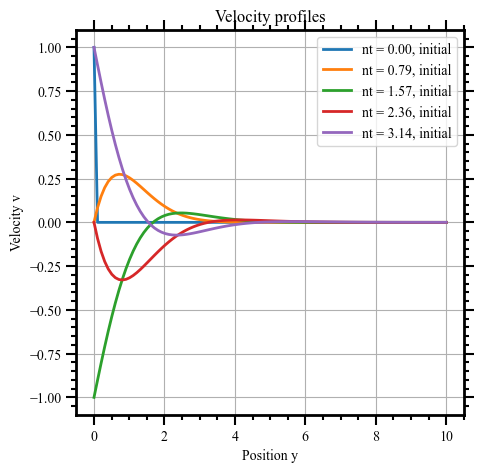

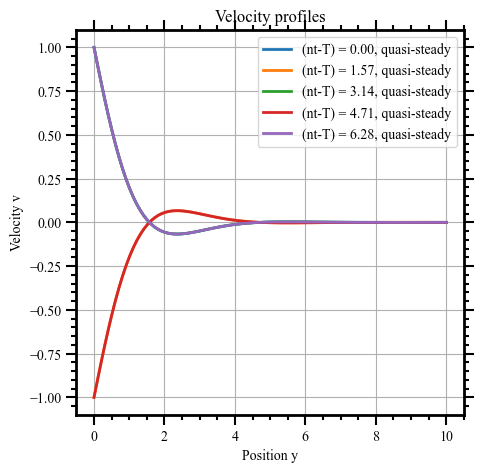

In [65]:
u = FTCS(T, L, n, nu, dt)

# Plotting for initial
for nt in nts:
    # t = nt/n
    nt = nt/n
    # for dataframe
    data = u[int(nt/dt), :]
    plt.plot(y, data, label=f'nt = {nt:.2f}, initial')
plt.legend(loc = 'upper right')
plt.xlabel('Position y')
plt.ylabel('Velocity v')
plt.title('Velocity profiles')
plt.grid(True)
plt.show()

# Plotting for quasi-steady
for nt in nts:
    idx = int((nt+T) / dt)
    data = u[idx, :]
    plt.plot(y, data, label=f'(nt-T) = {nt:.2f}, quasi-steady')
plt.legend(loc = 'upper right')
plt.xlabel('Position y')
plt.ylabel('Velocity v')
plt.title('Velocity profiles')
plt.grid(True)
plt.show()

#### Crank-Nicolson scheme

(2) Repeat (1) using the Crank-Nicolson (C-N) scheme in time.

A 행렬 생성 
$\alpha = 1/2$ 
upper diagonal: $\frac{-\nu * \Delta t}{(4 * \Delta y^2)}$  
diagonal : $\frac{1 + \nu * \Delta t}{(2 * \Delta y^2)}$  
lower diagonal : $\frac{-\nu * \Delta t}{(4 * \Delta y^2)}$  

b 벡터 생성:
$b = u[i, 1:-1] + \nu * \Delta t / (4 * \Delta y^2) * (u[i, :-2] - 2 * u[i, 1:-1] + u[i, 2:])$

In [70]:
def CN(T, L, n, nu, dt):
    """
    Crank-Nicolson scheme for solving a 1D heat equation.

    Parameters:
    - T: Total simulation time
    - L: Length of the domain
    - n: Oscillation frequency
    - nu: Diffusion coefficient
    - dt: Time step size

    Returns:
    - u_cn: Solution array
    """

    N = 100
    M = int(2 * T / dt)
    y = np.linspace(0, L, N)
    t = np.linspace(0, 2 * T, M)
    dy = y[1] - y[0]

    # Initialize u_cn array with boundary conditions
    u_cn = np.zeros((M, N))
    u_cn[:, 0] = np.cos(n * t)
    u_cn[:, -1] = 0

    # Crank-Nicolson scheme
    for i in range(M - 1):
        # Create A matrix for Crank-Nicolson
        A_upper = -nu * dt / (4 * dy**2) * np.ones(N - 2)
        A_mid = np.ones(N - 2) + nu * dt / (2 * dy**2)
        A_lower = -nu * dt / (4 * dy**2) * np.ones(N - 2)
        A = np.vstack((A_upper, A_mid, A_lower))

        # Create b vector for Crank-Nicolson
        b = u_cn[i, 1:-1] + nu * dt / (4 * dy**2) * (u_cn[i, :-2] - 2 * u_cn[i, 1:-1] + u_cn[i, 2:])

        # Solve Ax = b
        u_cn[i + 1, 1:-1] = solve_banded((1, 1), A, b)

    return u_cn


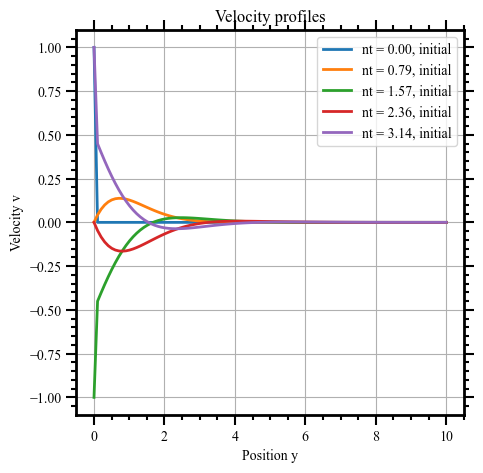

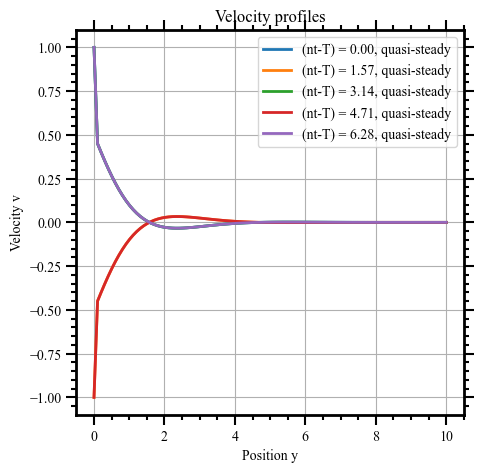

In [71]:
u_cn = CN(T, L, n, nu, dt)

# Plotting
for nt in nts:
    #t = nt/n
    nt = nt/n
    plt.plot(y, u_cn[int(nt/dt), :], label=f'nt = {nt:.2f}, initial')
    plt.legend()
plt.xlabel('Position y')
plt.ylabel('Velocity v')
plt.title('Velocity profiles')
plt.grid(True)
plt.show()

# Plotting
for nt in nts:
    idx = int((nt+T) / dt)
    data = u_cn[idx, :]
    plt.plot(y, data, label=f'(nt-T) = {nt:.2f}, quasi-steady')
    plt.legend()
plt.xlabel('Position y')
plt.ylabel('Velocity v')
plt.title('Velocity profiles')
plt.grid(True)
plt.show()


#### (4) Repeat (2) with L = 2. Discuss the effect of the gap distance between the two plates on the velocity profiles.

In [57]:
# Given parameters
nu = 1
n = 2
U0 = 1
L = 2
T = 10*np.pi
nts = np.array([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
dts = [0.1, 0.01, 0.0001]
N = 100
y = np.linspace(0, L, N)

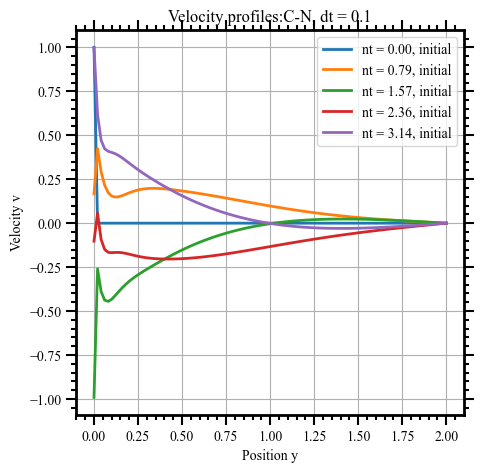

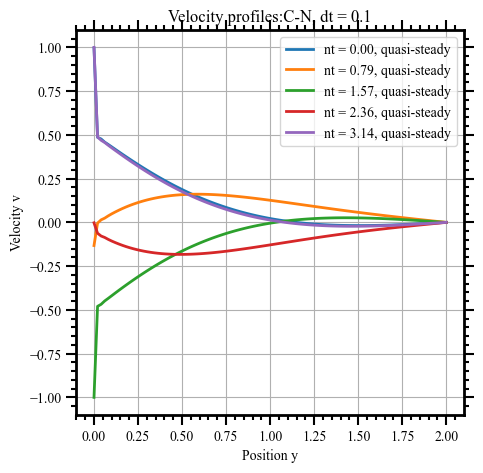

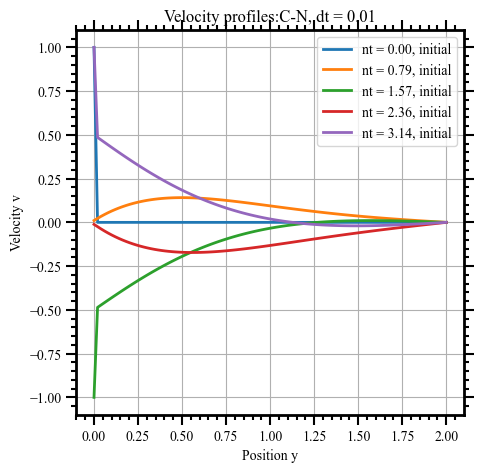

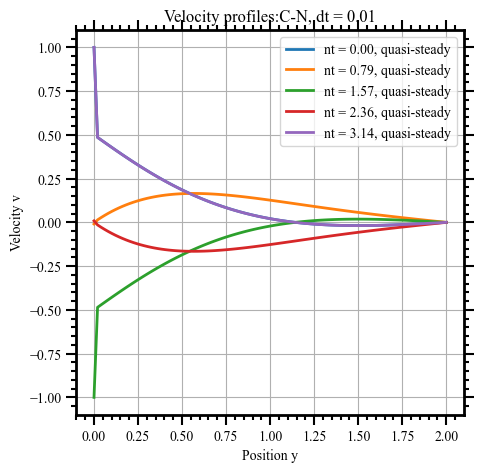

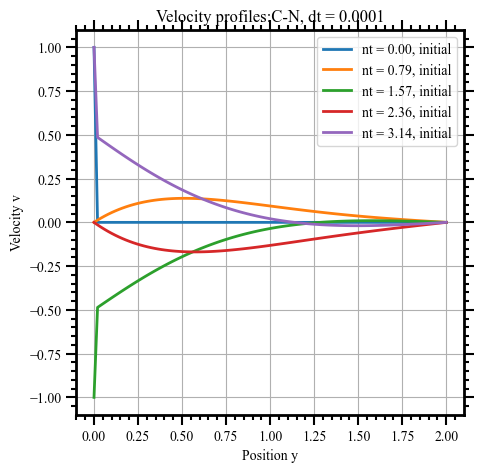

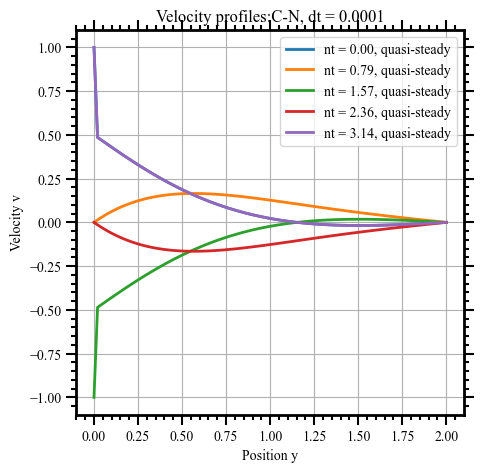

In [58]:
for dt in dts:
    u_cn = CN(T,L,n,nu,dt)
    # Plotting
    for nt in nts:
        #t = nt/n
        nt = nt/n
        plt.plot(y, u_cn[int(nt/dt), :], label=f'nt = {nt:.2f}, initial')
        plt.legend()
    plt.xlabel('Position y')
    plt.ylabel('Velocity v')
    plt.title(f'Velocity profiles:C-N, dt = {dt}')
    plt.grid(True)
    plt.show()

    # Plotting
    for nt in nts:
        # t = nt/n
        nt = nt/n
        idx = int((nt+T) / dt)
        data = u_cn[idx, :]
        plt.plot(y, data, label=f'nt = {nt:.2f}, quasi-steady')
        plt.legend()
    plt.xlabel('Position y')
    plt.ylabel('Velocity v')
    plt.title(f'Velocity profiles:C-N, dt = {dt}')
    plt.grid(True)
    plt.show()

gap distance가 줄어들면 진동이 강해진다..?